In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import torch

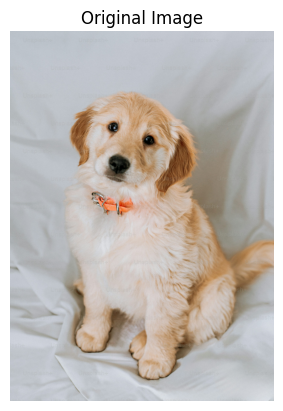

In [2]:
img = cv.imread('image.jpeg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show();

In [3]:
img = cv.imread('image.jpeg')
img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
L, a, b = cv.split(img)

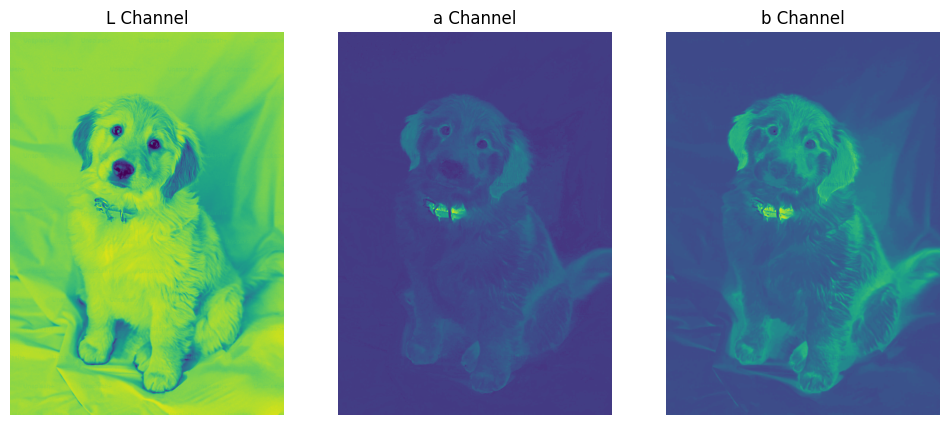

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(L)
ax[0].set_title('L Channel')
ax[0].axis('off')

ax[1].imshow(a)
ax[1].set_title('a Channel')
ax[1].axis('off')

ax[2].imshow(b)
ax[2].set_title('b Channel')
ax[2].axis('off')

plt.show();

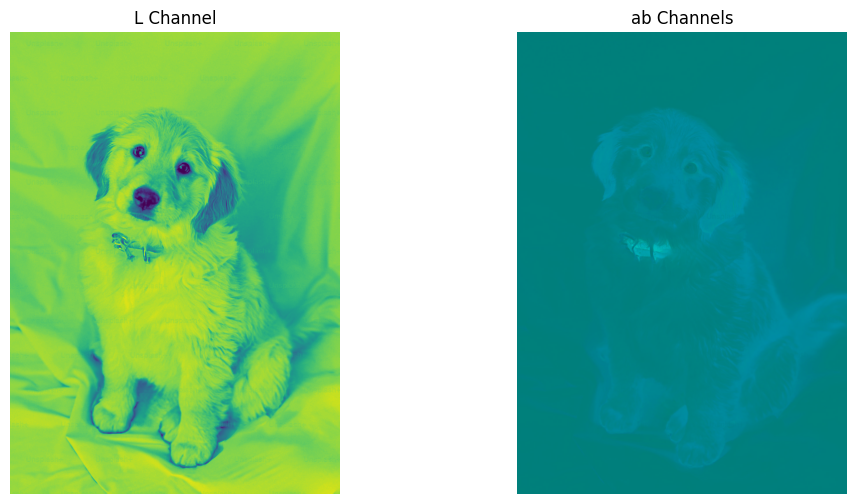

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(L)
ax[0].set_title('L Channel')
ax[0].axis('off')

ax[1].imshow(cv.merge([np.zeros_like(L), a, b]))
ax[1].set_title('ab Channels')
ax[1].axis('off')

plt.show();